## I'm returning to this after some delay to revisit the work I did.  gonna integrate everything into one nb

#### install dependencies and set data paths

In [0]:
from fastai import *
from fastai.tabular import *

import pandas as pd
import numpy as np

import os
import re
from collections import Counter

import random

from sklearn.metrics import confusion_matrix
import sklearn.metrics
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#use this cell when working online
path = '/floyd/home/ed-triage'
data_path = '/floyd/home/data/bch'
model_path = 'floyd/home/models'

In [0]:
#use this cell when working from home
path = '/Users/jjaskolkambp/Desktop/machine learning/my_projects/ed-triage'
data_path = '/Users/jjaskolkambp/Desktop/machine learning/my_projects/data/ED triage project/bch'

In [0]:
#use this cell in google colab
path = '/content/drive/My Drive/ML_data'
clin = pd.read_csv('/content/drive/My Drive/ML_data/complete_clean_combo_data.csv', index_col = 0,low_memory = False)

### First work on BCH data

#### load BCH data into DF (this is always slow)

In [0]:
clin = pd.read_csv(bch_data_path + '/bch_data.csv', low_memory = False)

In [4]:
clin.shape

(165957, 59)

In [0]:
clin.columns

Index(['Unnamed: 0', 'ID', 'ChartNumber', 'EncounterNumber', 'TriageLevel',
       'AgeNumber', 'AgeInYrs', 'GenderDesc', 'Triage Date & Time',
       'Reg Date & Time', 'PIA Date & Time', 'Disposition Date & Time',
       'DischargeDisposition', 'DischargeDispositionDesc',
       'Left ED Date & Time', 'PresentingComplaint', 'PresentingComplaintDesc',
       'MainDiagnosisCode', 'MainDiagnosisCodeDesc', 'AdmitLocation',
       'PatientService', 'SubjectiveNotes', 'InfectionControlScreening',
       'MedicalHistory', 'BloodPressure_LastEDReading',
       'O2Saturation_LastEDReading', 'Pulse_LastEDReading',
       'Temperature_LastEDReading',
       'Are you feeling feverish or have had shakes or chills in the last 24 hours?',
       'Have you ever been isolated/required isolation for an infectious disease when receiving care in a healthcare setting?',
       'Do you have a new Rash?',
       'Do you have a new onset of Vomiting/Diarrhea in the last 24 hours?',
       'Have you travelle

In [0]:
#drop incomplete records
clin.dropna(subset = ['SubjectiveNotes', 'MedicalHistory','InfectionControlScreening'], inplace = True)
clin.shape

(102543, 37)

In [0]:
date_columns = ['Triage Date & Time', 'Reg Date & Time']

clin.dropna(subset = date_columns, inplace = True)
clin.shape

(102492, 37)

In [0]:
clin.to_csv(data_path + '/100kcompleterecords.csv', index = False)

In [0]:
clin.columns

Index(['ID', 'ChartNumber', 'EncounterNumber', 'TriageLevel', 'AgeNumber',
       'AgeInYrs', 'GenderDesc', 'Triage Date & Time', 'Reg Date & Time',
       'PIA Date & Time', 'Disposition Date & Time', 'DischargeDisposition',
       'DischargeDispositionDesc', 'Left ED Date & Time',
       'PresentingComplaint', 'PresentingComplaintDesc', 'MainDiagnosisCode',
       'MainDiagnosisCodeDesc', 'AdmitLocation', 'PatientService',
       'SubjectiveNotes', 'InfectionControlScreening', 'MedicalHistory',
       'BloodPressure_LastEDReading', 'O2Saturation_LastEDReading',
       'Pulse_LastEDReading', 'Temperature_LastEDReading',
       'Are you feeling feverish or have had shakes or chills in the last 24 hours?',
       'Have you ever been isolated/required isolation for an infectious disease when receiving care in a healthcare setting?',
       'Do you have a new Rash?',
       'Do you have a new onset of Vomiting/Diarrhea in the last 24 hours?',
       'Have you travelled outside of Canada/U

#### refactoring some of the cells so they are clean and useful

In [0]:
o2sat = [item if item[-1] != '%' else item[:-1] for item in clin['O2Saturation_LastEDReading'].astype('str')]
o2sat = [np.nan if item == 'nan' else float(item) for item in o2sat] 
clin['o2sat'] = o2sat

In [0]:
pulse = clin['Pulse_LastEDReading']
pulse = [re.sub("[^0-9]", "", str(item)) for item in pulse]
pulse = [np.nan if item == '' else float(item) for item in pulse] 
#set(pulse)
clin['pulse'] = pulse

In [0]:
temp = clin['Temperature_LastEDReading']
temp = [re.sub("[^0-9]", "", str(item)) for item in temp]
temp = [np.nan if item == '' else float(item) for item in temp] 
temp = [item/10 if item > 100 else item for item in temp]
temp = [np.nan if item > 40  else item for item in temp]
#set(temp)
clin['temp'] = temp

In [0]:
def bptrans(bp):
    if pd.isnull(bp) or len(bp.split('/')) !=2:
        return [np.nan, np.nan]
    res = []
    for x in bp.split('/'):
        try:
            float(x)
            res =  [float(x) for x in bp.split('/')]
        except: 
            res =  [np.nan, np.nan]
        return res


In [0]:
clin['BP'] = clin.BloodPressure_LastEDReading.map(bptrans)

clin[['systolic', 'diastolic']] = pd.DataFrame(clin.BP.tolist(), index= clin.index)
clin["Gender"] = clin.GenderDesc.map(lambda x: 1 if x == "Male" else 0)

In [0]:
#this is to clean the text in the subjective notes column (a little bit)
def fixencode(s):
    if pd.isnull(s):
        s = "None"
    s = s[14:]
    s =s.replace('<LT><LF>','')
    s = s.replace('<LT>LF>','')
    s =s.replace('Pt.', 'patient')
    s =s.replace('Pt', 'patient')
    s = s.lower()
    s = s.replace('pt.', 'patient')
    s = s.replace('y/o', 'year old')
    s = s.replace('c/o', 'complains of')
    s = s.replace('sob', 'shortness of breath')
    s = s.replace('c/p', 'chest pain')
    s = s.replace('hrs', 'hours')
    s = s.replace('hx', 'history')
    s = s.replace('n/v', 'nausea and/or vomiting')
    s = s.replace('a/e', 'air entry')
    s = s.replace('a/o', 'alert and oriented')
    s = s.replace('a&o', 'alert and oriented')
    s = s.replace('d/c', 'discharge')
    s = s.replace('u/s', 'ultrasound')
    s = s.replace('yrs', 'years')
    s = s.replace('lmp', 'last menstrual period')
    s = s.replace('w/', 'with')
    s = s.replace('@', 'at ')
    s = s.replace('b/c', 'because')
    s = re.sub(r'\bpt.','patient ',s)
    s = re.sub(r'\blt.','left ',s)
    s = re.sub(r'\brt.','right ',s)
    s = re.sub(r'\bmd.','doctor ',s)
    s = re.sub(r'\bra\b','room air ',s)
    s = re.sub(r'\bbp.','blood pressure ',s)
    s = re.sub(r'\bcp.','chest pain ',s)
    s = re.sub(r'\bfd.','family doctor ',s)
    s = s.replace('abx', 'antibiotics')
    s = s.replace(' htn ', ' hypertension ')
    s = re.sub(r'\btyl\b', 'tylenol', s)
    s = re.sub(r'\bprn\b', 'as needed ',s)
    s = re.sub(r'\bvag\b', 'vaginal ',s)
    s = re.sub(r'\bpo\b', 'by mouth ',s)
    s = re.sub(r'\bllq\b', 'left lower quadrant',s)
    s = re.sub(r'\brlq\b', 'right lower quadrant  ',s)
    s = re.sub(r'\bluq\b', 'left upper quadrant',s)
    s = re.sub(r'\bruq\b', 'right upper quadrant  ',s)
    s = re.sub(r'\buti\b', 'urinary tract infection ',s)
    s = re.sub(r'\brd', 'right digit number',s)
    s = re.sub(r'\bld', 'left digit number',s)
    s = re.sub(r'\br\b', 'right ',s)
    s = re.sub(r'\bl\b', 'left ',s)
    s = re.sub(r'\bed\b', 'emergency department ',s)
    s = re.sub(r'\ber\b', 'emergency room ',s)
    s = re.sub(r'\bbm\b', 'bowel movement ',s)
    
    #remove extra white spaces
    s = re.sub(r'\s+', ' ', s)

    #note that what's missing here is removal of punctuation
    return s

In [0]:
clin['CleanSubjectiveNotes'] = clin.SubjectiveNotes.map(fixencode)

In [0]:
history = list(clin['MedicalHistory'].str[16:].astype('str'))

In [0]:
#this is to clean the text in the medical history column (a little bit)
def fixhx(s):
    s =s.replace('<LT><LF>','')
    s = s.replace('<LT>LF>','')
    s =s.replace('Pt.', 'patient')
    s =s.replace('Pt', 'patient')
    s = s.lower()
    s = s.replace('pt.', 'patient')
    s = s.replace('y/o', 'year old')
    s = s.replace('c/o', 'complains of')
    s = s.replace('sob', 'shortness of breath')
    s = s.replace('c/p', 'chest pain')
    s = s.replace('hrs', 'hours')
    s = s.replace('hx', 'history')
    s = s.replace('n/v', 'nausea and/or vomiting')
    s = s.replace('a/e', 'air entry')
    s = s.replace('a/o', 'alert and oriented')
    s = s.replace('a&o', 'alert and oriented')
    s = s.replace('d/c', 'discharge')
    s = s.replace('u/s', 'ultrasound')
    s = s.replace('yrs', 'years')
    s = s.replace('lmp', 'last menstrual period')
    s = s.replace('w/', 'with')
    s = s.replace('@', 'at ')
    s = s.replace('b/c', 'because')
    s = re.sub(r'\bpt.','patient ',s)
    s = re.sub(r'\blt.','left ',s)
    s = re.sub(r'\brt.','right ',s)
    s = re.sub(r'\bmd.','doctor ',s)
    s = re.sub(r'\bra\b','room air ',s)
    s = re.sub(r'\bbp.','blood pressure ',s)
    s = re.sub(r'\bcp.','chest pain ',s)
    s = re.sub(r'\bfd.','family doctor ',s)
    s = s.replace('abx', 'antibiotics')
    s = s.replace(' htn ', ' hypertension ')
    s = re.sub(r'\btyl\b', 'tylenol', s)
    s = re.sub(r'\bprn\b', 'as needed ',s)
    s = re.sub(r'\bvag\b', 'vaginal ',s)
    s = re.sub(r'\bpo\b', 'by mouth ',s)
    s = re.sub(r'\bllq\b', 'left lower quadrant',s)
    s = re.sub(r'\brlq\b', 'right lower quadrant  ',s)
    s = re.sub(r'\bluq\b', 'left upper quadrant',s)
    s = re.sub(r'\bruq\b', 'right upper quadrant  ',s)
    s = re.sub(r'\buti\b', 'urinary tract infection ',s)
    s = re.sub(r'\brd', 'right digit number',s)
    s = re.sub(r'\bld', 'left digit number',s)
    s = re.sub(r'\br\b', 'right ',s)
    s = re.sub(r'\bl\b', 'left ',s)
    s = re.sub(r'\bed\b', 'emergency department ',s)
    s = re.sub(r'\ber\b', 'emergency room ',s)
    s = re.sub(r'\bbm\b', 'bowel movement ',s)
    s = re.sub(r'#\s', 'fracture ', s)
    
    #remove extra white spaces
    s = re.sub(r'\s+', ' ', s)

    #note that what's missing here is removal of punctuation
    return s

In [0]:
replacements = (',','<LT>LF>', '.')
drop_list = ('"', '?')
split_hist = []
for item in history:
    for r in replacements:
        item = item.replace(r, '::')
    
    item = item.split('::')
    
    item = [re.sub(r'\(.*?\)\ *', '', s) for s in item]
    
    item = [fixhx(s) for s in item]
    for d in drop_list:
        item = [x.replace(d,'') for x in item]
    
    item = [x.strip().lower() for x in item if x != 'nan']
    item = [x for x in item if len(x) > 2]
    
    item = list(filter(None, item))
    
    split_hist.append(item)
    

In [0]:
#rejoining them as a string with diagnoses separated by commas
join_hist = [','.join(item) for item in split_hist]

In [0]:
comorbids = [len(item) if item != ['no significant medical history'] else 0 for item in split_hist]

In [0]:
#replacing empty string with NaN
join_hist = [np.nan if item == 'nan' else item for item in join_hist]

In [0]:
len(join_hist)

102492

In [0]:
clin['pmhx'] = join_hist

In [0]:
clin['num_comorbids'] = comorbids

#### making the target cells

In [0]:
admit_count= Counter(clin['AdmitLocation']); admit_count

Counter({nan: 92697,
         'N.SUR ORTH': 326,
         'N.MH CHADI': 113,
         'N.SUR SS': 448,
         'N.MH CHAD': 157,
         'N.MED CARD': 931,
         'N.MAU': 1543,
         'N.MED ONC': 591,
         'N.MED GER': 484,
         'N.CC ICU': 122,
         'N.SIMCU': 135,
         'N.SUR GEN': 714,
         'N.MED NEUR': 451,
         'N.MED CT': 97,
         'N.CC CCU': 292,
         'N.ER IN': 670,
         'N.MH INTEN': 156,
         'N.WC PAED': 860,
         'N.MH GER': 42,
         'N.MED RESP': 499,
         'N.MED SIM': 305,
         'N.MH GENC': 38,
         'N.MH GENB': 164,
         'N.MED SIX': 314,
         'N.MED DIAL': 29,
         'N.MED CPU': 152,
         'N.ERMH IN': 18,
         'N.WC POST': 88,
         'N.MAIN OR': 1,
         'N.CC NICU': 1,
         'N.MED FLEX': 4,
         'N.MED DSU': 49,
         'N.SUR DSU': 1})

In [0]:
clin['outcome'] = clin['AdmitLocation'].astype('str').map(
{'N.CC CCU': 'madmit',
 'N.CC ICU': 'ICU',
 'N.ER IN' : 'madmit',
 'N.ERMH IN': 'madmit',
 'N.MAU': 'madmit',
 'N.MED CARD': 'madmit',
 'N.MED CPU': 'madmit',
 'N.MED CT': 'madmit',
 'N.MED GER': 'madmit',
 'N.MED DIAL': 'madmit',
 'N.MED NEUR': 'madmit',
 'N.MED ONC': 'madmit',
 'N.MED RESP': 'madmit',
 'N.MED SIM': 'madmit',
 'N.MED SIX': 'madmit',
 'N.MH CHAD': 'madmit',
 'N.MH CHADI': 'madmit',
 'N.MH GENB': 'madmit',
 'N.MH GER': 'madmit',
 'N.MH INTEN': 'madmit',
 'N.SIMCU': 'ICU',
 'N.SUR GEN': 'sadmit',
 'N.SUR ORTH': 'sadmit',
 'N.SUR SS': 'sadmit',
 'N.WC PAED': 'madmit',
 'N.WC POST': 'madmit',
 'N.MH GENC': 'madmit',
 'N.CC NICU': 'ICU',
 'N.WC LD': 'sadmit',
  'N.WC LDN': 'sadmit',
  'N.MAIN OR': 'sadmit',
  'N.MED STTU': 'madmit',
  'N.MED FLEX': 'madmit',
    'N.MED DSU': 'madmit',
    'N.SUR DSU': 'sadmit',
 'nan': 'discharge'})

In [0]:
#first target columns is based on the admitting location
clin['target'] = clin['outcome'].map({'discharge': 1, 'madmit': 2, 'sadmit': 3, 'ICU': 4})

In [0]:
outcome_count = Counter(clin['outcome']); outcome_count

Counter({'discharge': 92697, 'sadmit': 1490, 'madmit': 8047, 'ICU': 258})

In [0]:
target_count = Counter(clin['target']); target_count

Counter({1: 92697, 3: 1490, 2: 8047, 4: 258})

In [0]:
clin['service'] = clin['PatientService'].astype('str').map(
    {'nan': 'discharge',
         'General Surgery': 'sadmit',
         'Respirology': 'madmit',
         'General Medicine': 'madmit',
         'INTENSIVE CARE UNIT': 'ICU',
         'Cardiology': 'madmit',
         'Oncology': 'madmit',
         'Palliative': 'madmit',
         'AD PALLIATIVE': 'madmit',
         'Genitourinary': 'sadmit',
         'Paediatrics': 'madmit',
         'Mental Health': 'madmit',
         'Orthopaedics': 'sadmit',
         'MH Child & Adolescent': 'madmit',
         'AD Oncology': 'madmit',
         'Neurology': 'madmit',
         'ALC General Medicine': 'madmit',
         'ALC General Surgery': 'sadmit',
         'Acute Care for Elders': 'madmit',
         'ALC Neurology': 'madmit',
         'ALC Cardiology': 'madmit',
         'ALC Respirology': 'madmit',
         'ALC Orthopaedics': 'madmit',
         'Neonatal Retro Transfers': 'madmit',
         'Newborn': 'madmit',
         'Obstetrics': 'madmit',
         'ALC Oncology': 'madmit',
         'AD General Medicine': 'madmit',
         'AD Acute Care for Elders': 'madmit',
         'AD Respirology': 'madmit',
         'ALC ACUTE CARE FOR EDLERS': 'madmit',
         'AD Cardiology': 'madmit',
         'AD Neurology': 'madmit',
         'ALC Palliative': 'madmit',
         'AD General Surgery': 'sadmit'})

In [0]:
service_count = Counter(clin['service'])
service_count

Counter({'discharge': 92697, 'sadmit': 1725, 'madmit': 7900, 'ICU': 170})

In [0]:
#second target is based on the admitting service
clin['target2'] = clin['service'].map({'discharge': 1, 'madmit': 2, 'sadmit': 3, 'ICU': 4})

In [0]:
target2_count = Counter(clin['target2']); target2_count

Counter({1: 92697, 3: 1725, 2: 7900, 4: 170})

In [0]:
#creating this for later use to map the numbers in the dataframe column to their original meaning
out_dict = {'discharge': 1, 'madmit': 2, 'sadmit': 3, 'ICU': 4}
out_dict = {v:k for k,v in out_dict.items()}
out_dict

{1: 'discharge', 2: 'madmit', 3: 'sadmit', 4: 'ICU'}

In [0]:
#discharge vs. not target
clin['discharge'] = clin['outcome'].map({'discharge': 'discharge', 'madmit': 'admit', 'sadmit': 'admit', 'ICU': 'admit'})

In [0]:
clin['target3'] = clin['outcome'].map({'discharge': 1, 'madmit': 0, 'sadmit': 0, 'ICU': 0})

In [0]:
Counter(clin['discharge']), Counter(clin['target3'])

(Counter({'discharge': 92697, 'admit': 9795}), Counter({1: 92697, 0: 9795}))

In [0]:
#a target for trying to tell apart the inpatient disposition, only in admitted patients
clin['dispo']= clin['outcome'].map({'discharge': np.nan, 'madmit': 'madmit', 'sadmit': 'sadmit', 'ICU': 'ICU'})

In [0]:
clin['target4'] = clin['dispo'].map({np.nan:np.nan, 'madmit': 1, 'sadmit': 2, 'ICU': 3})
#for some reason a can't make a counter out of this without it crashing so I've stopped trying

In [0]:
Counter(clin['dispo']), Counter(clin['target4'].dropna())

(Counter({nan: 92697, 'sadmit': 1490, 'madmit': 8047, 'ICU': 258}),
 Counter({2.0: 1490, 1.0: 8047, 3.0: 258}))

In [0]:
#gonna make a target that is ICU vs other
clin['ICUvsother'] = clin['PatientService'][clin['PatientService'] == 'INTENSIVE CARE UNIT']
#clin['PatientService']

In [0]:
clin['target5'] = clin['ICUvsother'].map({'INTENSIVE CARE UNIT':1, np.nan:0})

#### now gonna do the date columns using fast ai

In [5]:
clin.shape

(165957, 59)

In [0]:
date_columns = ['Triage Date & Time', 'Reg Date & Time']
for col in date_columns:
    add_datepart(clin, col, drop = False, time = True)
    add_cyclic_datepart(clin, col, time = True)

In [9]:
clin.shape

(165957, 121)

In [0]:
clin.to_csv(data_path + '/100kcompleterecords.csv', index = False)

### now on to the fast ai part

let's remember this dictionary so we know what the various targets are:

outcome: {'discharge': 106689, 'madmit': 12037, 'sadmit': 2061, 'ICU': 479}

service: {'discharge': 106689, 'madmit': 12003, 'sadmit': 2278, 'ICU': 296}

discharge: {'discharge': 106689, 'admit': 14577}

dispo: {nan: 106689, 'madmit': 12037, 'sadmit': 2061, 'ICU': 479})(for admitted patients only, where did they go?

ICUvsother:  self explanatory

In [0]:
cat_names =[
 'Triage Date & TimeIs_month_end',
 'Triage Date & TimeIs_month_start',
 'Triage Date & TimeIs_quarter_end',
 'Triage Date & TimeIs_quarter_start',
 'Triage Date & TimeIs_year_end',
 'Triage Date & TimeIs_year_start',
 'Reg Date & TimeIs_month_end',
 'Reg Date & TimeIs_month_start',
 'Reg Date & TimeIs_quarter_end',
 'Reg Date & TimeIs_quarter_start',
 'Reg Date & TimeIs_year_end',
 'Reg Date & TimeIs_year_start',
 'GenderDesc',
 'PresentingComplaintDesc',
 'MainDiagnosisCodeDesc',
 'Are you feeling feverish or have had shakes or chills in the last 24 hours?',
 'Have you ever been isolated/required isolation for an infectious disease when receiving care in a healthcare setting?',
 'Do you have a new Rash?',
 'Do you have a new onset of Vomiting/Diarrhea in the last 24 hours?',
 'Have you travelled outside of Canada/USA in the last 3 weeks?',
 'Have you had contact with a sick person who has travelled outside of Canada/USA in the last 3 weeks?',
 'Have you received Health Care in another country in the last 2 years?',
 'Do you have a new/worse cough or shortness of breath?',
 'If so, select all countries that apply',
 'If so, select all infectious diseases that apply'
]


In [0]:
cont_names = [
 'AgeNumber',
 'Triage Date & TimeYear',
 'Triage Date & TimeMonth',
 'Triage Date & TimeWeek',
 'Triage Date & TimeDay',
 'Triage Date & TimeDayofweek',
 'Triage Date & TimeDayofyear',
 'Triage Date & TimeHour',
 'Triage Date & TimeMinute',
 'Triage Date & TimeSecond',
 'Triage Date & TimeElapsed',
 'Reg Date & TimeYear',
 'Reg Date & TimeMonth',
 'Reg Date & TimeWeek',
 'Reg Date & TimeDay',
 'Reg Date & TimeDayofweek',
 'Reg Date & TimeDayofyear',
 'Reg Date & TimeHour',
 'Reg Date & TimeMinute',
 'Reg Date & TimeSecond',
 'Reg Date & TimeElapsed',
 'num_comorbids']

In [0]:

procs = [FillMissing, Categorify, Normalize]

In [0]:
test = TabularList.from_df(clin.copy(),cat_names=cat_names, cont_names=cont_names)

In [0]:
valid_idxs = random.sample(range(len(clin)), len(clin)//5)

In [0]:
valid_df = pd.DataFrame(valid_idxs)
valid_df.to_csv(path + '/valid_idxs.csv', index=False)

In [52]:
len(test), len(valid_idxs)

(165957, 33191)

In [0]:
dep_var = 'discharge'  

data = (TabularList.from_df(clin, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idxs)
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [0]:
data.save(path + '/tabulardb')

In [0]:
#f1 = FBeta(beta=1, average = 'weighted')

learn = tabular_learner(data, layers=[100,50], metrics=[accuracy])


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


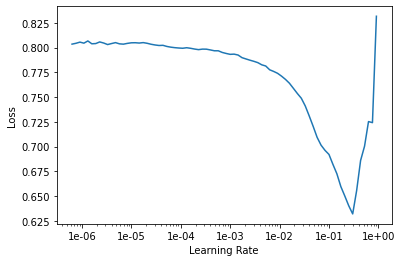

In [55]:
learn.lr_find()
learn.recorder.plot()

In [56]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.213584,0.229091,0.912868,00:46
1,0.208851,0.216282,0.916935,00:50
2,0.205636,0.213470,0.919255,00:50
3,0.190218,0.212242,0.919828,00:49
4,0.188574,0.211652,0.919225,00:45


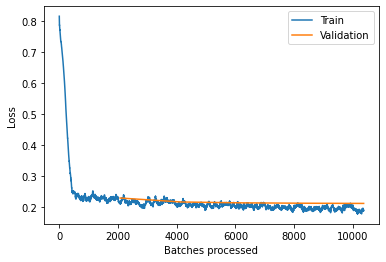

In [57]:
learn.recorder.plot_losses()

In [58]:
preds, targets = learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

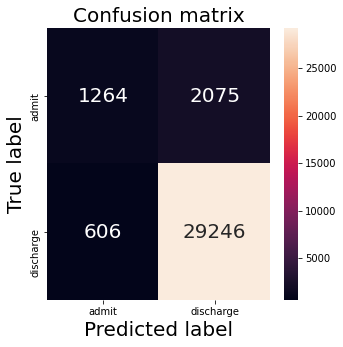

In [59]:
LABELS = data.classes

confusion_matrix = sklearn.metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [60]:
f1_w = sklearn.metrics.f1_score(targets, predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, predictions)
prec = sklearn.metrics.precision_score(targets,predictions, average = None)
rec = sklearn.metrics.recall_score(targets,predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)


weighted f1:  0.9088052070494043
f1:           [0.485314 0.956173]
accuracy:     0.9192250911391643
precision:    [0.675936 0.933751]
recall:       [0.378556 0.9797  ]


In [0]:
clin = pd.read_csv('/content/drive/My Drive/ML_data/balanced_admit_dc_combo_data.csv', index_col = 0,low_memory = False)

In [0]:
date_columns = ['Triage Date & Time', 'Reg Date & Time']
for col in date_columns:
    add_datepart(clin, col, drop = False, time = True)
    add_cyclic_datepart(clin, col, time = True)

In [28]:
clin.shape

(32758, 121)

In [0]:
cat_names =[
 'Triage Date & TimeIs_month_end',
 'Triage Date & TimeIs_month_start',
 'Triage Date & TimeIs_quarter_end',
 'Triage Date & TimeIs_quarter_start',
 'Triage Date & TimeIs_year_end',
 'Triage Date & TimeIs_year_start',
 'Reg Date & TimeIs_month_end',
 'Reg Date & TimeIs_month_start',
 'Reg Date & TimeIs_quarter_end',
 'Reg Date & TimeIs_quarter_start',
 'Reg Date & TimeIs_year_end',
 'Reg Date & TimeIs_year_start',
 'GenderDesc',
 'PresentingComplaintDesc',
 'MainDiagnosisCodeDesc',
 'Are you feeling feverish or have had shakes or chills in the last 24 hours?',
 'Have you ever been isolated/required isolation for an infectious disease when receiving care in a healthcare setting?',
 'Do you have a new Rash?',
 'Do you have a new onset of Vomiting/Diarrhea in the last 24 hours?',
 'Have you travelled outside of Canada/USA in the last 3 weeks?',
 'Have you had contact with a sick person who has travelled outside of Canada/USA in the last 3 weeks?',
 'Have you received Health Care in another country in the last 2 years?',
 'Do you have a new/worse cough or shortness of breath?',
 'If so, select all countries that apply',
 'If so, select all infectious diseases that apply'
]


In [0]:
cont_names = [
 'AgeNumber',
 'Triage Date & TimeYear',
 'Triage Date & TimeMonth',
 'Triage Date & TimeWeek',
 'Triage Date & TimeDay',
 'Triage Date & TimeDayofweek',
 'Triage Date & TimeDayofyear',
 'Triage Date & TimeHour',
 'Triage Date & TimeMinute',
 'Triage Date & TimeSecond',
 'Triage Date & TimeElapsed',
 'Reg Date & TimeYear',
 'Reg Date & TimeMonth',
 'Reg Date & TimeWeek',
 'Reg Date & TimeDay',
 'Reg Date & TimeDayofweek',
 'Reg Date & TimeDayofyear',
 'Reg Date & TimeHour',
 'Reg Date & TimeMinute',
 'Reg Date & TimeSecond',
 'Reg Date & TimeElapsed',
 'num_comorbids']

In [0]:

procs = [FillMissing, Categorify, Normalize]

In [0]:
test = TabularList.from_df(clin.copy(),cat_names=cat_names, cont_names=cont_names)

In [0]:
valid_idxs = random.sample(range(len(clin)), len(clin)//5)

In [31]:
len(test), len(valid_idxs)

(32758, 6551)

In [0]:
dep_var = 'discharge'  

data = (TabularList.from_df(clin, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idxs)
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [0]:
data.save(path + '/tabulardb')

In [0]:
#f1 = FBeta(beta=1, average = 'weighted')

learn = tabular_learner(data, layers=[200,100], metrics=[accuracy])


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


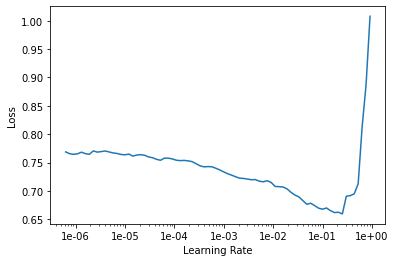

In [34]:
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.356489,0.431890,0.811021,00:08
1,0.350106,0.432528,0.807816,00:08
2,0.356679,0.432999,0.809189,00:08
3,0.350061,0.434635,0.809189,00:08
4,0.351976,0.437307,0.812242,00:08
5,0.342573,0.443178,0.805068,00:08
6,0.344181,0.438542,0.806900,00:08
7,0.333394,0.443989,0.808274,00:08
8,0.342947,0.445694,0.808426,00:08
9,0.325650,0.446917,0.807205,00:08


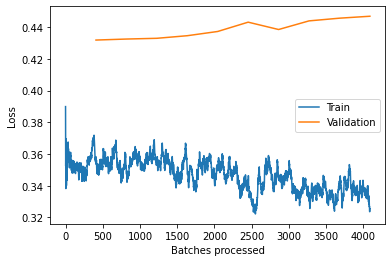

In [41]:
learn.recorder.plot_losses()

In [42]:
preds, targets = learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

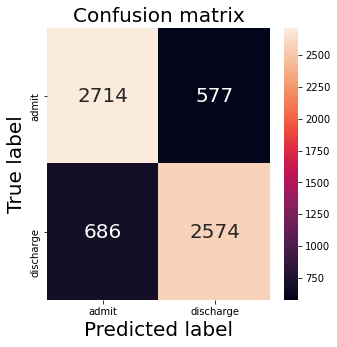

In [43]:
LABELS = data.classes

confusion_matrix = sklearn.metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [44]:
f1_w = sklearn.metrics.f1_score(targets, predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, predictions)
prec = sklearn.metrics.precision_score(targets,predictions, average = None)
rec = sklearn.metrics.recall_score(targets,predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)


weighted f1:  0.8071364211845805
f1:           [0.811239 0.802995]
accuracy:     0.8072050068691803
precision:    [0.798235 0.816884]
recall:       [0.824673 0.789571]


#### now gonna try again with a different target - ICU vs other

In [0]:
dep_var = 'target5'

test = TabularList.from_df(clin.copy(),cat_names=cat_names, cont_names=cont_names)

valid_idxs = random.sample(range(len(clin)), len(clin)//5)

data = (TabularList.from_df(clin, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idxs)
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

learn2 = tabular_learner(data, layers=[200,100], metrics=[accuracy])

In [0]:
learn2.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.009135,0.010627,0.998439,00:23
1,0.013064,0.010234,0.998439,00:23
2,0.010707,0.009592,0.998439,00:23
3,0.007843,0.062234,0.998439,00:23
4,0.006302,0.010187,0.998439,00:23


In [0]:
preds, targets = learn2.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

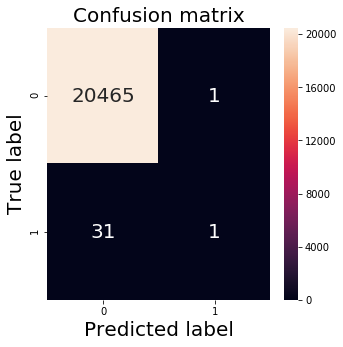

In [0]:
LABELS = data.classes

confusion_matrix = sklearn.metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [0]:
f1_w = sklearn.metrics.f1_score(targets, predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, predictions)
prec = sklearn.metrics.precision_score(targets,predictions, average = None)
rec = sklearn.metrics.recall_score(targets,predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)


weighted f1:  0.9977507108556443
f1:           [0.999219 0.058824]
accuracy:     0.9984388720850814
precision:    [0.998488 0.5     ]
recall:       [0.999951 0.03125 ]


In [0]:
clin = pd.read_csv(data_path + '/100kcompleterecords.csv')

In [0]:
dep_var = 'service'

test = TabularList.from_df(clin.copy(),cat_names=cat_names, cont_names=cont_names)

valid_idxs = random.sample(range(len(clin)), len(clin)//5)

data = (TabularList.from_df(clin, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idxs)
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())
learn3 = tabular_learner(data, layers=[200,100], metrics=[accuracy])

In [0]:
learn3.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.247050,0.251622,0.917699,00:24
1,0.245402,0.242654,0.922041,00:24
2,0.226665,0.234371,0.924041,00:24
3,0.212135,0.232763,0.923749,00:24
4,0.206278,0.233248,0.923993,00:24


In [0]:
preds, targets = learn3.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

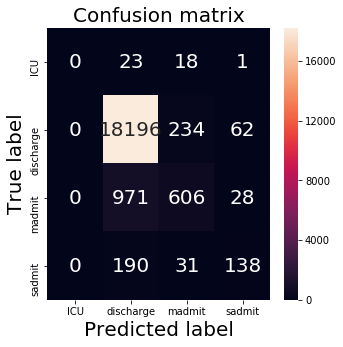

In [0]:
LABELS = data.classes

confusion_matrix = sklearn.metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [0]:
f1_w = sklearn.metrics.f1_score(targets, predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, predictions)
prec = sklearn.metrics.precision_score(targets,predictions, average = None)
rec = sklearn.metrics.recall_score(targets,predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)


weighted f1:  0.913154318648459
f1:           [0.       0.960921 0.485966 0.469388]
accuracy:     0.9239925846424042
precision:    [0.       0.938906 0.681665 0.60262 ]
recall:       [0.       0.983993 0.37757  0.384401]


In [0]:
dep_var = 'outcome'

test = TabularList.from_df(clin.copy(),cat_names=cat_names, cont_names=cont_names)

valid_idxs = random.sample(range(len(clin)), len(clin)//5)

data = (TabularList.from_df(clin, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idxs)
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())
learn4 = tabular_learner(data, layers=[200,100], metrics=[accuracy])

In [0]:
learn4.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.259874,0.245116,0.922090,00:23
1,0.243131,0.235890,0.922871,00:24
2,0.220609,0.242940,0.923310,00:23
3,0.218350,0.266943,0.922431,00:24
4,0.204541,0.264989,0.923651,00:23


In [0]:
preds, targets = learn4.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

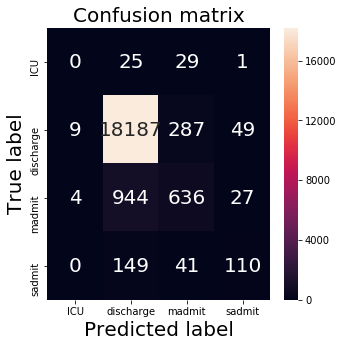

In [0]:
LABELS = data.classes

confusion_matrix = sklearn.metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [0]:
f1_w = sklearn.metrics.f1_score(targets, predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, predictions)
prec = sklearn.metrics.precision_score(targets,predictions, average = None)
rec = sklearn.metrics.recall_score(targets,predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)


weighted f1:  0.9141334793413808
f1:           [0.       0.961334 0.488479 0.451745]
accuracy:     0.9236510879110157
precision:    [0.       0.942088 0.640483 0.588235]
recall:       [0.       0.981384 0.394786 0.366667]
